## Pytorch MRI image class

The purpose of this notebook is to work out a class that I an consistently use for the super-resolution and just general image training of MRI and potentially other medical imaging data types.

It's become clear that everyone seems to have a different, unique, way of loading and organizing their data into a format that can be fed into a Pytorch `Dataset` for training a model. This can include creating intermediate `.png` images in order to limit memory usage/training time on personal hardware.

Goals for this tool:
1. Given an input folder, list all files that match a particular `prefix` and `suffix`
2. Display sample images from the list for assurance
3. Create randomly shuffled/altered images at different resolutions (gaussian blur, affine transformation, etc.)
    - Make the aspect of saving these images optional
4. Save any image generated in a specified format
5. Be given an input and output folder and generate list of matching data
6. Have locations of matching low and high resolution images (potentially a list for every x2 magnification)


Output file labeling protocol:
To keep things consistent I should probably create a labeling structure that is robust to future changes that I might want to make. This will most likely have to be stored in the string name, unless I want to make an intermediate file that is used as a key for the location of the files relative to the directory.

## Import necessary libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import numpy as np
from PIL import Image
import random
import cv2
from matplotlib import pyplot
from skimage.transform import rotate, AffineTransform, warp, rescale

## Class definition

In [140]:
# The super resolution class:

class sr_gen():
    def __init__(self, inp_dir, HR_out_dir, LR_out_dir, prefix='', suffix=''):
        self.inp_dir = inp_dir
        self.HR_out_dir = HR_out_dir
        self.LR_out_dir = LR_out_dir
        self.inp_files = self.__get_inp__(prefix, suffix)
        self.template = self.get_template()

    def __get_inp__(self, prefix, suffix):
        # Get the original files that will be used to generate everything
        # Based on the prefix, for now this could be nifti files or png's.
        # Will have to write a "try" statement in order to check for file type
        files = []
        for fil in os.listdir(self.inp_dir):
            if fil.startswith(prefix) & fil.endswith(suffix):
                files.append(fil)
        
        if not files:
            raise FileNotFoundError('No applicable files found in input directory')

        return files

    def __get_LR_out__(self):
        # get list of files in output directory and determine matching files
        return os.listdir(self.LR_out_dir)

    def __get_HR_out__(self):
        return os.listdir(self.HR_out_dir)


    def __view_sample__(self):
        # Function which loads and displays random example image for sanity check
        pyplot.imshow(Image.open(self.inp_dir + self.inp_files[random.randint(0,len(self.inp_files)-1)]))


    def get_template(self):
        # Returns dictonary of all option settings for this class
        try:
            return self.template
        except:
            return {'resolution':2,
                    'translation_x':10,
                    'translation_y':10,
                    'rotation':0,
                    'scale':2,
                    'patch':False,
                    'step': 10,
                    'save_blank':False,
                    }

    def save_template(self, temp):
        # apply the provided template for randomization to self for access by other functions
        self.template = temp


    def gen_pair(self):
        # Generate transformed low resolution and high resolution images

        # Inputs:
        #   recipe: [dict] dictionary consisting of operations to be performed on images

        pass


    def run(self, clear=False):
        # Run the analysis specified in the template dictionary. If clear is true then the 
        # files in the output directories will be deleted before creating the new images.

        # Make the directories where the new files will be saved
        os.makedirs(self.HR_out_dir, exist_ok=True)
        os.makedirs(self.LR_out_dir, exist_ok=True)

        HR_out_files = []
        LR_out_files = []
        
        s = 1/self.template['resolution']
        for im in self.inp_files:
            im_h = np.array(Image.open(self.inp_dir + im))

            # check the dimensions of the image
            #print(f'Shape of High Resolution Image:{im_h.shape}')

            im_h = self.rgb2ycrbcr(im_h)
            im_h = im_h[:,:,0] #Just deal with intensity values at the moment because 
                                # having multiple channels throws off cv2 when saving, 
                                # since it also does BGR instead of RGB and will save a blue image

            # TODO: compare cv2.resize with skimage.rescale or pytorch rescale for this
            im_l = cv2.resize(im_h, (0,0), fx = s, fy =s, interpolation=cv2.INTER_CUBIC)
            im_l = cv2.resize(im_l, (0,0), fx = self.template['resolution'],
            fy=self.template['resolution'], interpolation=cv2.INTER_CUBIC)
            # TODO: The above resizing results in values outside of the range [0, 255] due to 
            # the INTER_CUBIC method. For now I'm just clipping the values, but a more nuanced
            # answer should be found
            im_l = np.clip(im_l, 0, 255)

            print(f'HR image shape = {im_h.shape}')
            print(f'LR image shape = {im_h.shape}')

            if self.template['patch']:
                _ = self.img2patches(self.img_transform(im, im_h, im_l), save=True)
            else:
                _ = self.img_transform(im, im_h, im_l, save=True)
            
            HR_out_files.append(_)


    def img_transform(self,im, im_h, im_l, save=False):
        # Transform the original files using a variety of methods

        opp = '' #string for storing the operations performed on the images

        # If shifting in the x or y direction was selected
        if self.template['translation_x'] > 0 | self.template['translation_y'] > 0:
            _a = np.random.randint(0,self.template['translation_x'])
            _b = np.random.randint(0,self.template['translation_y'])
            transform = AffineTransform(translation=(_a, _b))
            im_h = warp(im_h, transform,mode='reflect')
            im_l = warp(im_l, transform,mode='reflect')
            opp += f'_x{_a}_y{_b}'

        if self.template['scale'] > 1:
            _a = np.random.randint(1,self.template['scale']+1)
            transform = AffineTransform(scale=_a)
            im_h = warp(im_h, transform, mode='reflect')
            im_l = warp(im_l, transform,mode='reflect')
            opp+= f'_scale{_a}'

        # If rotation was selected
        if self.template['rotation'] > 0:
            _a = np.random.randint(0,self.template['rotation'])
            im_h = rotate(im_h, _a, mode="reflect")
            im_l = rotate(im_l, _a, mode="reflect")
            opp+= f'_rot{_a}'

        opp = im.split('.')[0] + opp

        if save:
            print(f'Saving image: {opp}')
            cv2.imwrite(f'{self.HR_out_dir}/{opp}.png', im_h)
            cv2.imwrite(f'{self.LR_out_dir}/{opp}.png', im_l)
        else:
            return opp, im_h, im_l

    def img2patches(self, im, im_h, im_l=False, keep_blank=False, save=False):
        # Take a given image and generate patches and returns a stack of images
        # im : str, name of the image being cut into patches
        # im_h : ndarray, numpy array of the high-resolution image
        # im_l : ndarray, numpy array of the low-resolution image. If this is false, 
        # then you only want to make patches from one image (in this case im_h)

        patch_size = self.template['patch']
        step = self.template['step']


        # Get the height and width of the provided images
        h_h, w_h = im_h.shape
        h_l, w_l = im_l.shape

        # Create a numpy stack following Pytorch protocols
        HR_stack = np.zeros((len(range(0,w_h,step))*len(range(0,h_h,step))),h_h,w_h)
        if im_l:
            LR_stack = np.zeros((len(range(0,w_h,step))*len(range(0,h_h,step))),h_h,w_h)

        im_name = im.split('.')[0]

        cnt = 0
        blank = 0

        for i in range(0,w_h,step):
            for j in range(0,h_h,step):
                while i+patch_size < w_h & j+patch_size < h_h:

                    sample_h = im_h[j:j+patch_size, i: i+patch_size]
                    if im_l:
                        sample_l = im_l[j:j+patch_size, i:i+patch_size]

                    # if you've chosen to keep blank patches or if the patch is not blank add 
                    # it to the stack
                    if keep_blank | (sample_h.max() > 0 | sample_l.max() > 0):
                        HR_stack[cnt, :,:] = sample_h
                        if im_l:
                            LR_stack[cnt,:,:] = sample_l
                        cnt += 1
                    else:
                        blank += 1


                        
        if save: #Whether to save a patch if it is blank/intensity value of 0
            for i in range(cnt):
                cv2.imwrite(f'{self.HR_out_dir}/{im_name}_{cnt}.png', sample_h)
                if im_l:
                    cv2.imwrite(f'{self.LR_out_dir}/{im_name}_{cnt}.png', sample_l)
        else:
            # Return a list of image names and numpy array with the first cnt layers
            HR_fnames = []
            for i in range(cnt):
                HR_fnames.append(f'{im_name}_{i}.png')

            if im_l:
                return list(zip(HR_fnames, HR_fnames)), HR_stack[:cnt,:,:], LR_stack[:cnt,:,:]
            else:
                return HR_fnames, HR_stack[:cnt,:,:]
        


    def rgb2ycrbcr(self, img_rgb):
        # Takes an RBG image and returns it as a YCRBCR image (if you just want to focus
        #  on luminance values of an image)

        img_rgb = img_rgb.astype(np.float32)

        img_ycrcb = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2YCR_CB)
        img_ycbcr = img_ycrcb[:,:,(0,2,1)].astype(np.float32)
        img_ycbcr[:,:,0] = (img_ycbcr[:,:,0]*(235-16)+16)/255.0
        img_ycbcr[:,:,1:] = (img_ycbcr[:,:,1:]*(240-16)+16)/255.0

        return img_ycbcr



    def match_altered(self):
        # Get the files that have been generated in the output directory
        ex_files = self.__get_out__()

        # Get a set of all the files with agreement before the metadata
        if len(ex_files) > len(self.inp_files):
            # TODO: add stripping function to remove metadata from string name
            matches = list(set(ex_files)-(set(ex_files)-set(self.inp_files)))
        else:
            matches = list(set(self.inp_files)-(set(self.inp_files)-set(ex_files)))

        return matches

    def change_inp(self, inp_dir, out_dir, prefix='', suffix=''):
        # Change which set of images are viewed as the inputs and outputs
        self.inp_files = self.__get_inp__(prefix, suffix)
        self.out_files = self.__get_out__()


In [141]:
qq = sr_gen('./data/raw/nii_sub_HR/','./data/raw/HR_output/','./data/raw/LR_output')

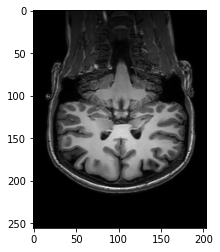

In [142]:
qq.__view_sample__()

In [143]:
im_h = qq.run()

HR image shape = (256, 204)
LR image shape = (256, 204)
Saving image: 141_scale2
HR image shape = (256, 204)
LR image shape = (256, 204)
Saving image: 155_scale1
HR image shape = (256, 204)
LR image shape = (256, 204)
Saving image: 140_scale1
HR image shape = (256, 204)
LR image shape = (256, 204)
Saving image: 147_scale1
HR image shape = (256, 204)
LR image shape = (256, 204)
Saving image: 145_scale1
HR image shape = (256, 204)
LR image shape = (256, 204)
Saving image: 154_scale2
HR image shape = (256, 204)
LR image shape = (256, 204)
Saving image: 157_scale1
HR image shape = (256, 204)
LR image shape = (256, 204)
Saving image: 151_scale2
HR image shape = (256, 204)
LR image shape = (256, 204)
Saving image: 153_scale2
HR image shape = (256, 204)
LR image shape = (256, 204)
Saving image: 148_scale1
HR image shape = (256, 204)
LR image shape = (256, 204)
Saving image: 149_scale1
HR image shape = (256, 204)
LR image shape = (256, 204)
Saving image: 156_scale1
HR image shape = (256, 204)


In [98]:
im_h[:,:,0].max()

219.06274

In [128]:
grayim = np.zeros(im_h.shape)
grayim[:,:,0]= grayim[:,:,1] = grayim[:,:,2] = im_h[:,:,0]

cv2.imwrite('test.png',grayim[:,:,0])

True

In [138]:
np.array(Image.open('./data/raw/HR_output/140_scale1.png')).shape

(256, 204, 3)

In [71]:
temp = qq.get_template()
temp["patch"]=True
qq.save_template(temp)

In [34]:
a = {'1','2','3','2'}
b = {'1','2'}

In [1]:
a = {'b':20,
'c':50}

In [91]:
np.random.randint(2)

0

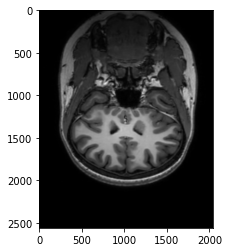

In [123]:
pyplot.imshow(rescale(np.array(Image.open('./data/raw/nii_HR/104.png')),10,mode='symmetric',multichannel=True))

In [145]:
a = ['this','list','is','cool']
b = ['how','about','this','list']
list(zip(a,b))

[('this', 'how'), ('list', 'about'), ('is', 'this'), ('cool', 'list')]

In [55]:
np.random.randint(1,2)

1